### **Columbia University**
### **ECBM E4040 Neural Networks and Deep Learning. Fall 2021.**

## **Task 2: RNN application -- Tweet Sentiment Analysis**

In this task, you are going to classify the sentiment in tweets into positive and negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using using one hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimenssionality redution. 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load Data


In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## **Part 1 LSTM Encoder**

**TODO**: Create a single-layer LSTM network to classify tweets. Use one hot encoding to represent each word in the tweet. Set LSTM units to 100. Use Adam optimizer and set batch size to 64.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional). 

(tf.one_hot and Keras functional API may be useful).

In [5]:
###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################

train_tweets_onehot = tf.one_hot(train_tweets, depth=1000)
test_tweets_onehot = tf.one_hot(test_tweets, depth=1000)

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(20, 1000), return_sequences=True))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=opt,
    metrics=["accuracy"],
)
history_LSTM = model.fit(train_tweets_onehot, train_labels, batch_size=64, epochs=15, validation_data=(test_tweets_onehot, test_labels)) 

###################################################
# END TODO                                        #
###################################################

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 100)           440400    
_________________________________________________________________
dense_1 (Dense)              (None, 20, 1)             101       
Total params: 440,501
Trainable params: 440,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
938/938 [==============================] - 14s 14ms/step - loss: 0.6148 - accuracy: 0.6522 - val_loss: 0.5798 - val_accuracy: 0.6921
Epoch 2/15
938/938 [==============================] - 12s 13ms/step - loss: 0.5543 - accuracy: 0.7108 - val_loss: 0.5633 - val_accuracy: 0.6953
Epoch 3/15
938/938 [==============================] - 12s 13ms/step - loss: 0.5453 - accuracy: 0.7130 - val_loss: 0.5582 - val_accuracy: 0.6987
Epoch 4/15
938/938 [==============================] - 12s 13ms/step - loss: 0.

## **Part 2: Embedding Lookup layer**

**Define an embedding layer**

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling.

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

**TODO**: Define a similar model as above with one change. Use an Embedding layer instead of one hot embedding. Also, write a custom training loop to train the model instead of using model.fit(). Writing a custom loop gives you complete control over how the model is trained. Refer to the link below.

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

Report loss and accuracy for training and validation after each epoch. Also, display the loss value after every 400 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?


Solution: Both the training and validation accuracy is higher compared with One-Hot encoding. So embedding output (more dense) is better for improving the accuracy in this probelm setting The training time is 145.74s per epoch which is slower. However this comparsion is unfair as the embedding traning is implemented using for loop (even without @tf.function to speed up the computation).

In [4]:
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################

model = tf.keras.Sequential() 
model.add(tf.keras.layers.Embedding(input_dim=len(vocabulary), output_dim=1000))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

batch_size = 64
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()
train_dataset = tf.data.Dataset.from_tensor_slices((train_tweets, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((test_tweets, test_labels))
val_dataset = val_dataset.batch(batch_size)

import time
epochs = 15
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_acc_metric.update_state(y_batch_train, logits)

        if step % 400 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    train_acc_metric.reset_states()

    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))

###################################################
# END TODO                                        #
###################################################

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 1000)        7597000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               440400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 8,037,501
Trainable params: 8,037,501
Non-trainable params: 0
_________________________________________________________________

Start of epoch 0
Training loss (for one batch) at step 0: 0.7018
Seen so far: 64 samples
Training loss (for one batch) at step 400: 0.6931
Seen so far: 25664 samples
Training loss (for one batch) at step 800: 0.6931
Seen so far: 51264 samples
Training acc over epoch: 0.4993
Validation acc: 0.4879
Time taken: 143.22s

Start of epoch 1
Training loss (for one batch) at step

## **TODO:**  **Visualize word vectors via tSNE**

First, you need to retrieve embedding matrix from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector.

And then, you should visualize some interesting word pairs in 2D panel. You may find scatter function in matplotlib.pyplot useful.

Hint: You can use TSNE tool provided in scikit-learn. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.

In [23]:
###################################################
# TODO: Visualize word vectors using TSNE.        #
#                                                 #
###################################################

female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]

embeddings = model.layers[0].get_weights()[0]
vocab2idx = {}
for idx, word in enumerate(vocabulary):
    vocab2idx[word] = idx
def getIndex(word):
    return embeddings[vocab2idx[word],:]

###################################################
# END TODO                                        #
###################################################

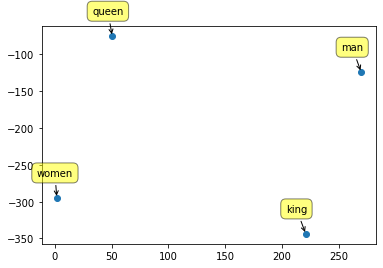

In [24]:
# Get idea from https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_demo.html
from sklearn.manifold import TSNE
import matplotlib.pyplot

bbox_args = dict(boxstyle='round', pad=0.5, fc='yellow', alpha=0.5)
arrow_args = dict(arrowstyle="->", connectionstyle='arc3')

X = np.array([embeddings[vocab2idx["man"],:], embeddings[vocab2idx["women"],:],
              embeddings[vocab2idx["king"],:], embeddings[vocab2idx["queen"],:]])

tsne_gender = TSNE(n_components=2, random_state=0).fit_transform(X)

matplotlib.pyplot.scatter(tsne_gender[:,0], tsne_gender[:,1])
labels = ["man", "women", "king", "queen"]
for label, x, y in zip(labels, tsne_gender[:, 0], tsne_gender[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='left', va='bottom',
        bbox=bbox_args,
        arrowprops=arrow_args)
matplotlib.pyplot.show()

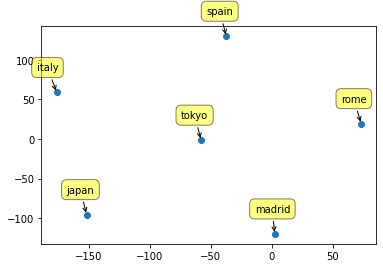

In [25]:
X = np.array([embeddings[vocab2idx["spain"],:], embeddings[vocab2idx["madrid"],:],
              embeddings[vocab2idx["italy"],:], embeddings[vocab2idx["rome"],:],
              embeddings[vocab2idx["japan"],:], embeddings[vocab2idx["tokyo"],:]])

tsne_capital = TSNE(n_components=2).fit_transform(X)

matplotlib.pyplot.scatter(tsne_capital[:,0], tsne_capital[:,1])
labels = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
for label, x, y in zip(labels, tsne_capital[:, 0], tsne_capital[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='left', va='bottom',
        bbox=bbox_args,
        arrowprops=arrow_args)
matplotlib.pyplot.show()